In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
import cv2
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files=[]
paths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Leukemia-full/images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path)
        files.append(filename)


In [ ]:
mpaths = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Leukemia-full/masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mpaths.append(path)

In [ ]:
df0=pd.DataFrame(columns=['file','path','mpath'])
df0['file']=sorted(files)
df0['path']=sorted(paths)
df0['mpath']=sorted(mpaths)
df=df0.iloc[0:243]
test_df=df0.iloc[243:]

In [ ]:
img_size = [512,512]

def data_augmentation(cell_img, mask_img):
    if tf.random.uniform(()) > 0.5:
        cell_img = tf.image.flip_left_right(cell_img)
        mask_img = tf.image.flip_left_right(mask_img)

    return cell_img, mask_img

def preprocessing(cell_path, mask_path):
    cell_img = tf.io.read_file(cell_path)
    cell_img = tf.image.decode_jpeg(cell_img, channels=3)
    cell_img = tf.image.resize(cell_img, img_size)
    cell_img = tf.cast(cell_img, tf.float32) / 255.0

    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]
    mask_img = tf.math.sign(mask_img)

    return cell_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["path"].values, df["mpath"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [ ]:
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)
test = create_dataset(test_df)

In [ ]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
    plt.figure(figsize=(12,12))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

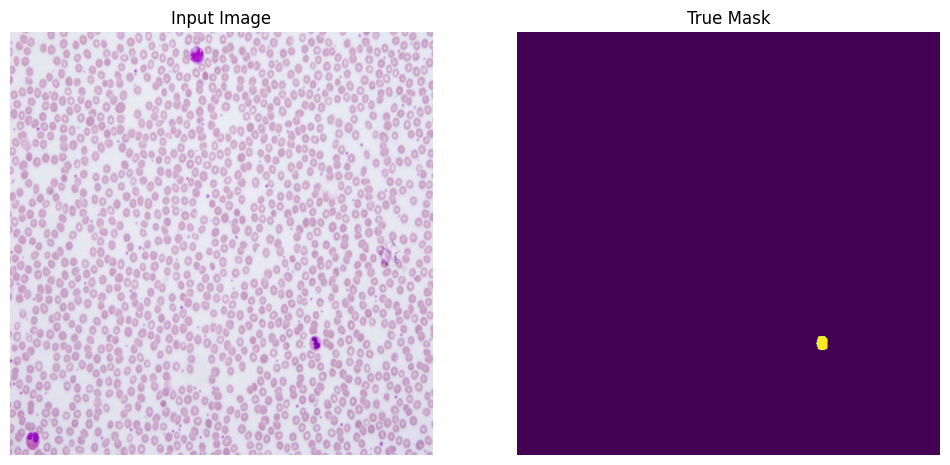

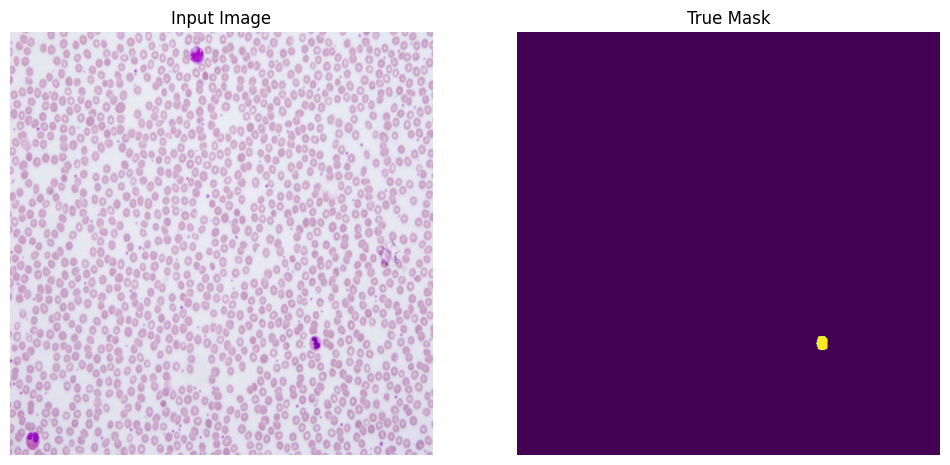

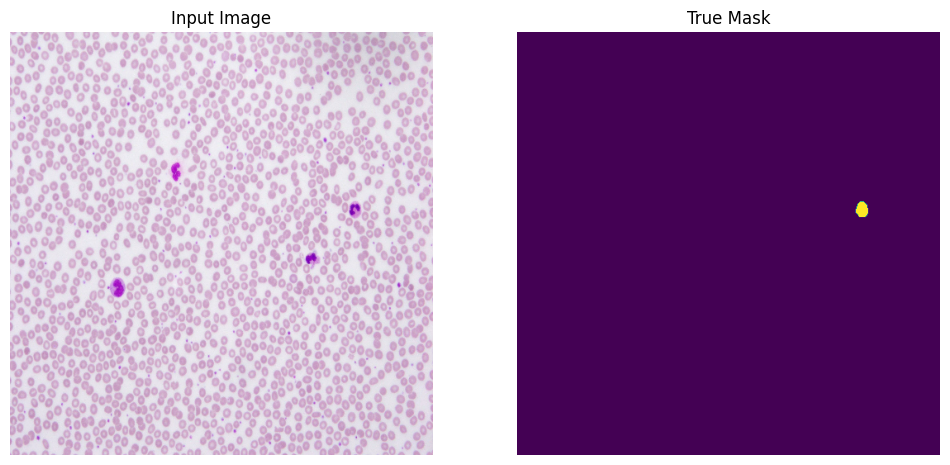

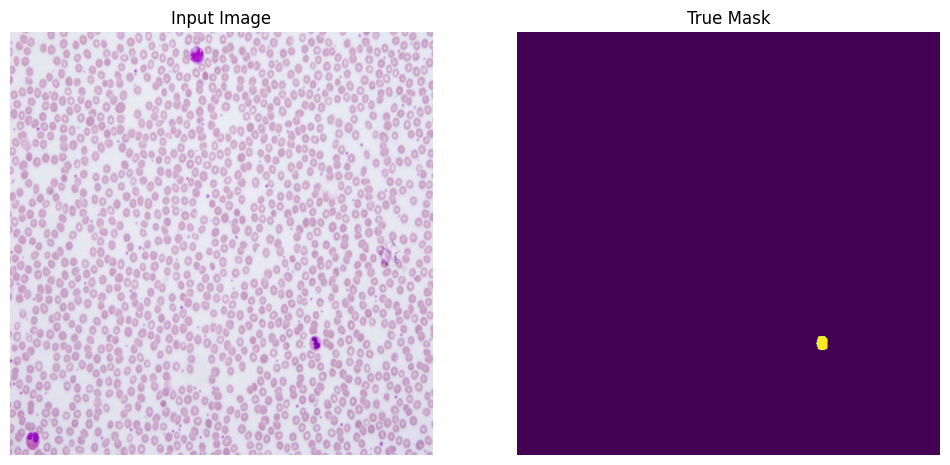

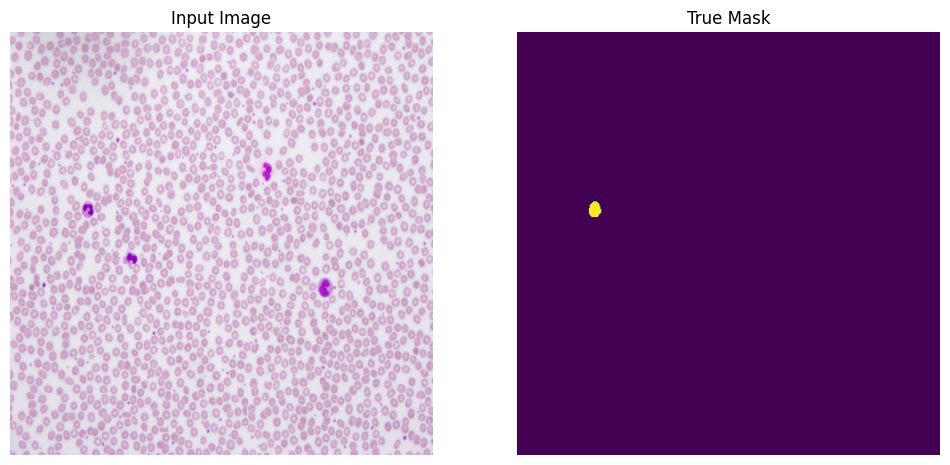

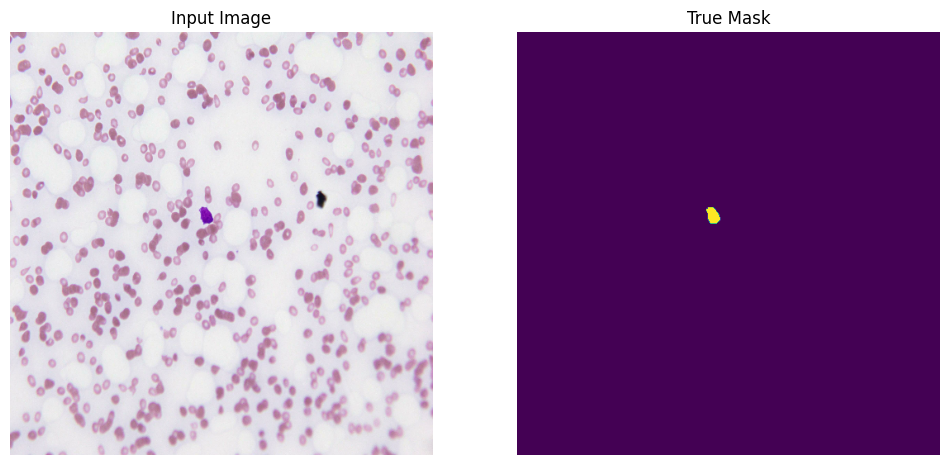

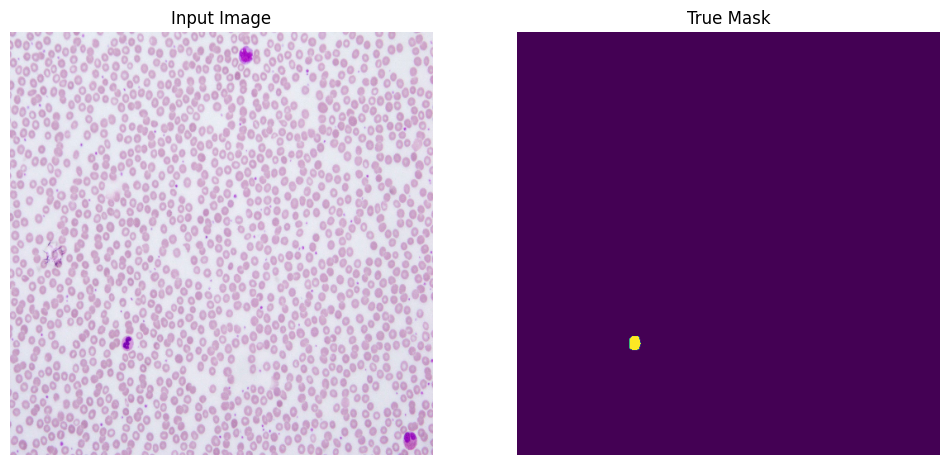

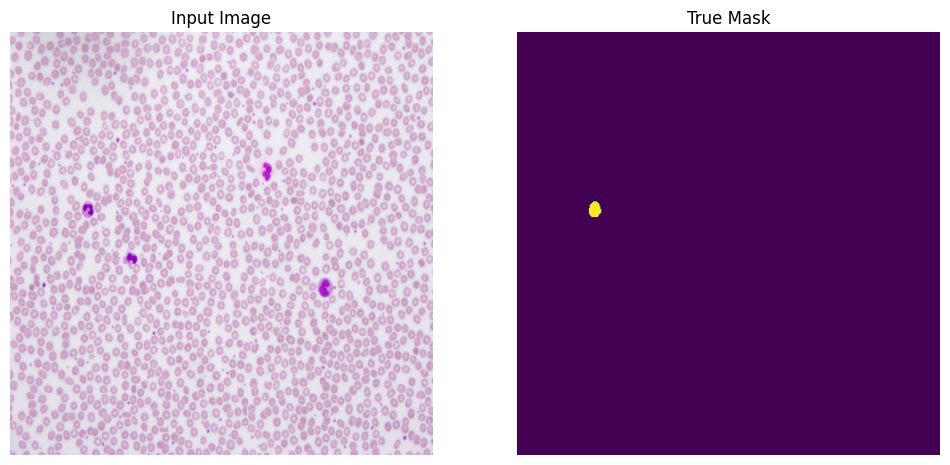

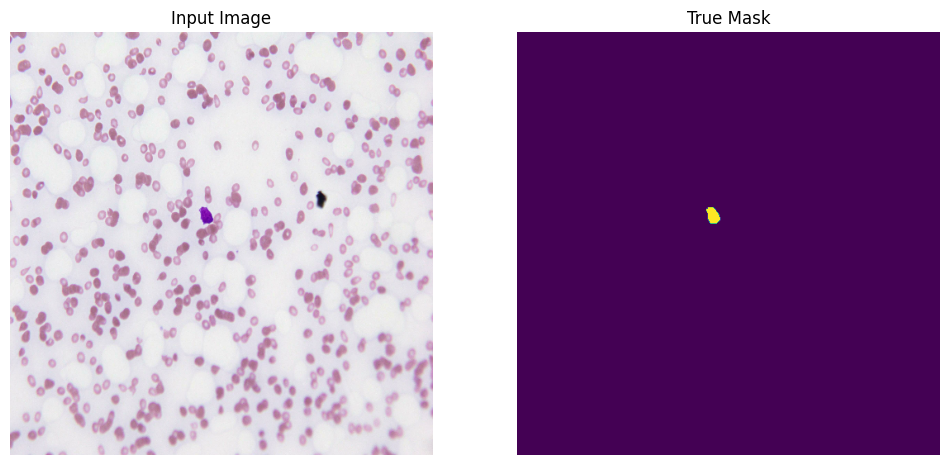

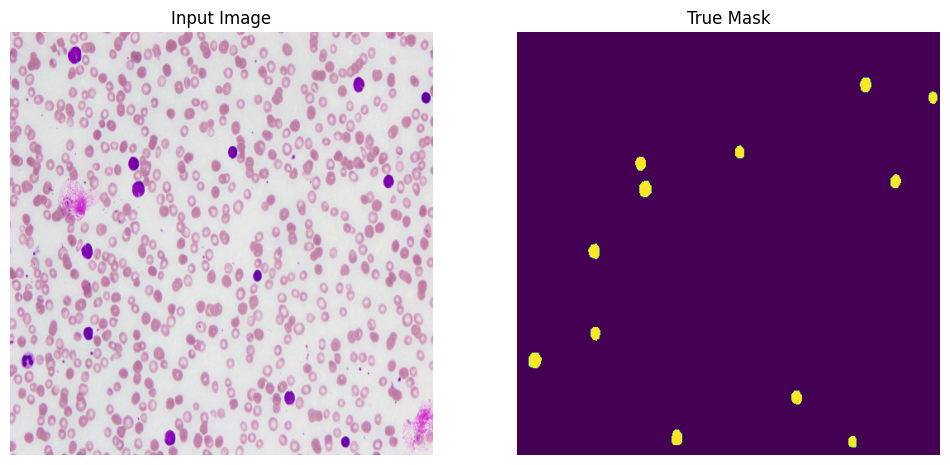

In [ ]:
for i in range(5):
    for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 2, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

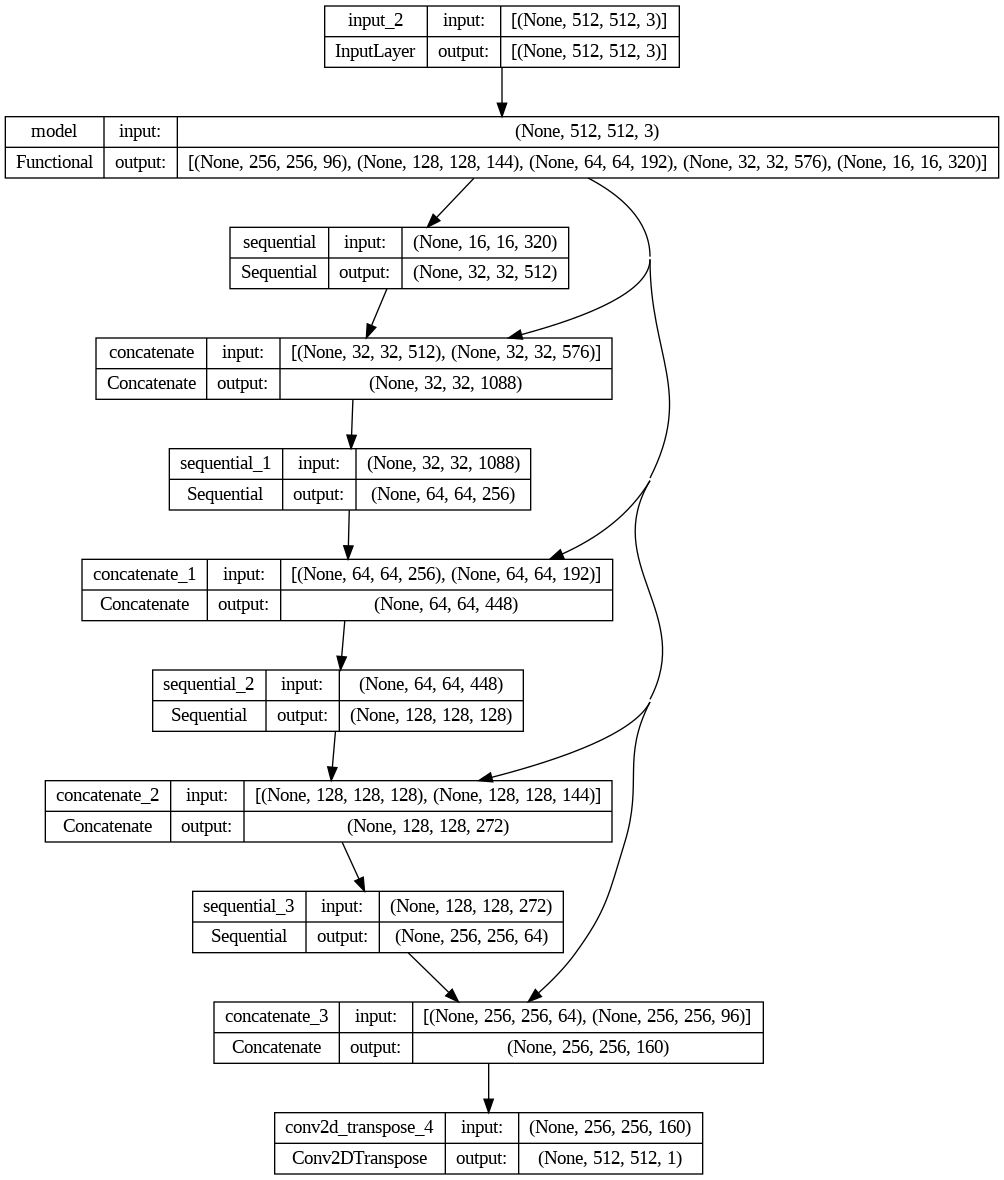

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def visualize(display_list):
    plt.figure(figsize=(12,12))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

In [ ]:
def deleteFiles():
  # Define the directory where your files are located
  directory = '/content/'

  # Find all files starting with "cropped" in the specified directory
  files = glob.glob(os.path.join(directory, 'cropped_roi_*'))

  # Iterate over the files and delete them
  for file in files:
      try:
          os.remove(file)
          print(f"Deleted file: {file}")
      except OSError as e:
          print(f"Error deleting file: {file} - {e}")

Epoch 1/30
11/11 [==============================] - 372s 32s/step - loss: 0.9853 - dice_coef: 0.0147 - binary_accuracy: 0.4941 - val_loss: 0.9897 - val_dice_coef: 0.0102 - val_binary_accuracy: 0.2531
Epoch 2/30
1/1 [==============================] - 2s 2s/step


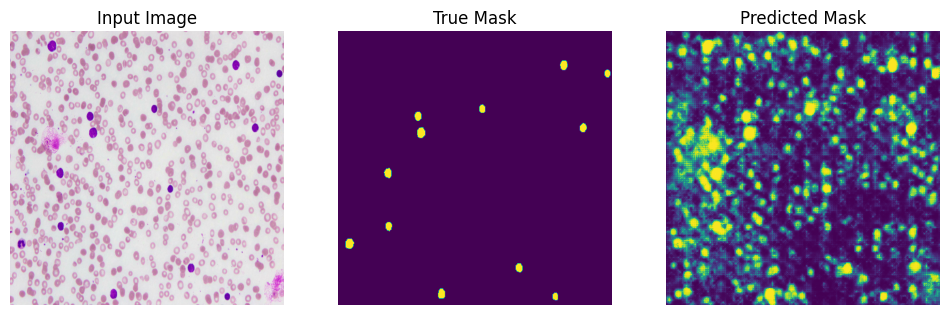

Epoch 3/30
11/11 [==============================] - 333s 31s/step - loss: 0.8400 - dice_coef: 0.1570 - binary_accuracy: 0.8108 - val_loss: 0.7583 - val_dice_coef: 0.2361 - val_binary_accuracy: 0.7461
Epoch 4/30
11/11 [==============================] - 322s 30s/step - loss: 0.6931 - dice_coef: 0.3015 - binary_accuracy: 0.8454 - val_loss: 0.6463 - val_dice_coef: 0.3488 - val_binary_accuracy: 0.7408
Epoch 5/30
1/1 [==============================] - 1s 559ms/step


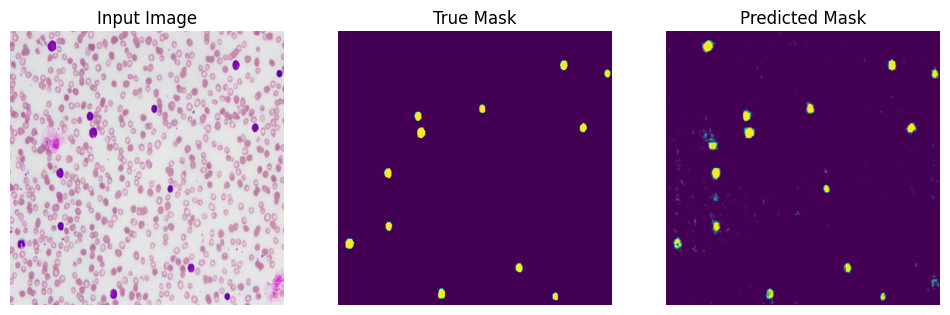

Epoch 6/30
11/11 [==============================] - 314s 29s/step - loss: 0.5016 - dice_coef: 0.4990 - binary_accuracy: 0.9179 - val_loss: 0.5144 - val_dice_coef: 0.4820 - val_binary_accuracy: 0.8079
Epoch 7/30
11/11 [==============================] - 318s 30s/step - loss: 0.4760 - dice_coef: 0.5128 - binary_accuracy: 0.9594 - val_loss: 0.5059 - val_dice_coef: 0.4908 - val_binary_accuracy: 0.9940
Epoch 8/30
1/1 [==============================] - 1s 809ms/step


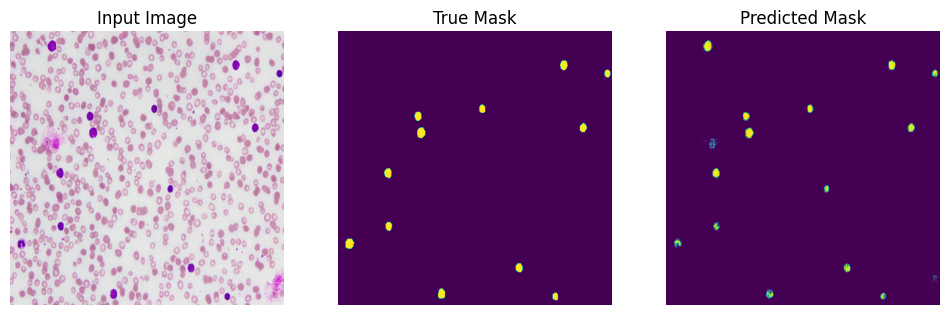

Epoch 9/30
11/11 [==============================] - 282s 26s/step - loss: 0.2749 - dice_coef: 0.7221 - binary_accuracy: 0.9984 - val_loss: 0.3731 - val_dice_coef: 0.6256 - val_binary_accuracy: 0.9982
Epoch 10/30
11/11 [==============================] - 273s 25s/step - loss: 0.2477 - dice_coef: 0.7552 - binary_accuracy: 0.9985 - val_loss: 0.3778 - val_dice_coef: 0.6203 - val_binary_accuracy: 0.9982
Epoch 11/30
1/1 [==============================] - 1s 510ms/step


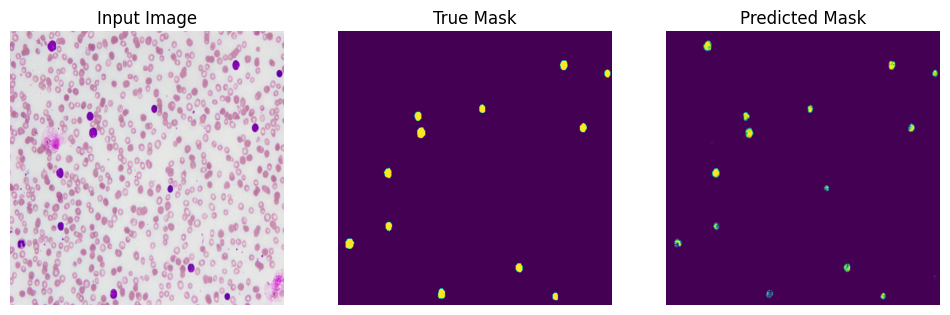

Epoch 12/30
11/11 [==============================] - 312s 29s/step - loss: 0.2167 - dice_coef: 0.7851 - binary_accuracy: 0.9987 - val_loss: 0.3576 - val_dice_coef: 0.6417 - val_binary_accuracy: 0.9982
Epoch 13/30
11/11 [==============================] - 334s 31s/step - loss: 0.2096 - dice_coef: 0.7904 - binary_accuracy: 0.9987 - val_loss: 0.3732 - val_dice_coef: 0.6264 - val_binary_accuracy: 0.9982
Epoch 14/30
1/1 [==============================] - 1s 517ms/step


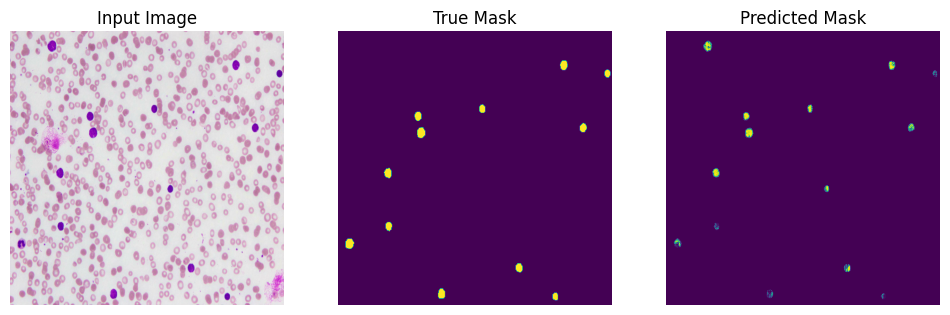

Epoch 15/30
11/11 [==============================] - 322s 30s/step - loss: 0.1988 - dice_coef: 0.7975 - binary_accuracy: 0.9988 - val_loss: 0.4161 - val_dice_coef: 0.5834 - val_binary_accuracy: 0.9980
Epoch 16/30
11/11 [==============================] - 323s 30s/step - loss: 0.1963 - dice_coef: 0.8077 - binary_accuracy: 0.9988 - val_loss: 0.3492 - val_dice_coef: 0.6505 - val_binary_accuracy: 0.9982
Epoch 17/30
1/1 [==============================] - 1s 505ms/step


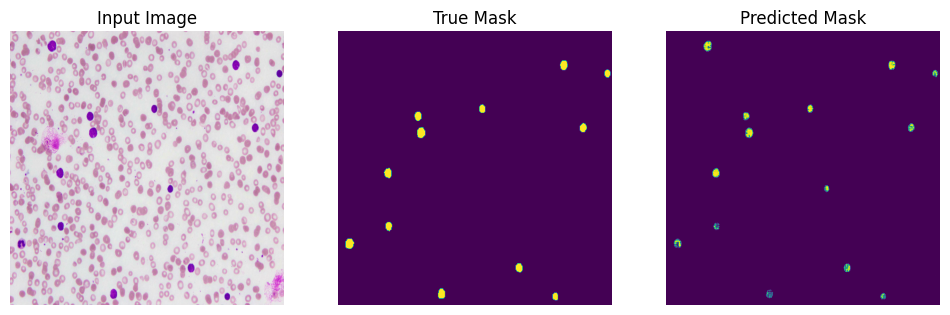

Epoch 18/30
11/11 [==============================] - 314s 29s/step - loss: 0.1664 - dice_coef: 0.8352 - binary_accuracy: 0.9990 - val_loss: 0.3453 - val_dice_coef: 0.6543 - val_binary_accuracy: 0.9983
Epoch 19/30
11/11 [==============================] - 323s 29s/step - loss: 0.1799 - dice_coef: 0.8204 - binary_accuracy: 0.9989 - val_loss: 0.3429 - val_dice_coef: 0.6576 - val_binary_accuracy: 0.9983
Epoch 20/30
1/1 [==============================] - 0s 488ms/step


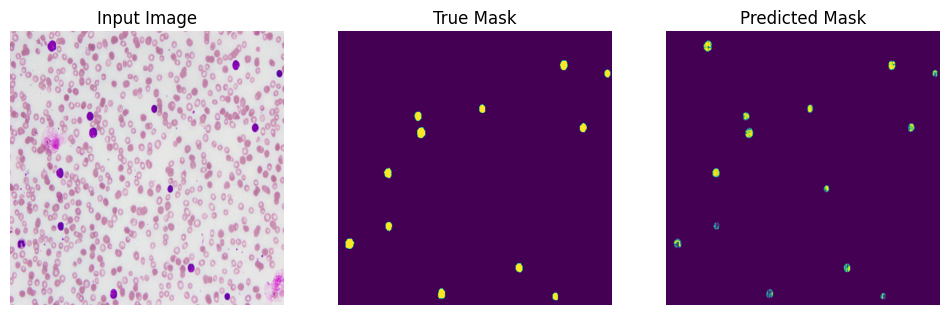

Epoch 21/30
11/11 [==============================] - 321s 29s/step - loss: 0.1655 - dice_coef: 0.8326 - binary_accuracy: 0.9990 - val_loss: 0.3590 - val_dice_coef: 0.6415 - val_binary_accuracy: 0.9982
Epoch 22/30
11/11 [==============================] - 269s 25s/step - loss: 0.1759 - dice_coef: 0.8257 - binary_accuracy: 0.9990 - val_loss: 0.3731 - val_dice_coef: 0.6277 - val_binary_accuracy: 0.9982
Epoch 23/30
1/1 [==============================] - 1s 543ms/step


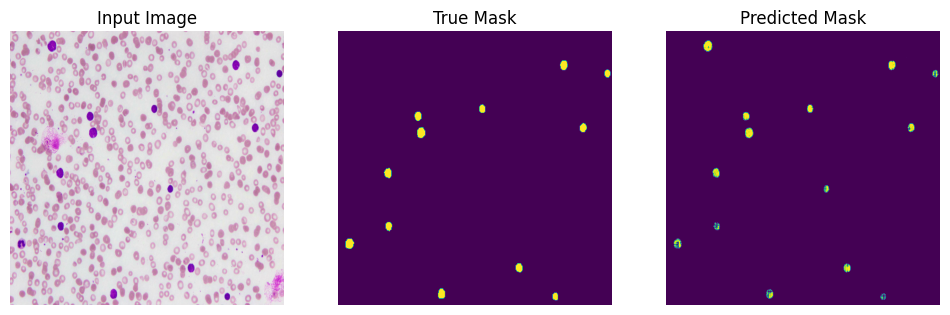

Epoch 24/30
11/11 [==============================] - 312s 29s/step - loss: 0.1624 - dice_coef: 0.8390 - binary_accuracy: 0.9991 - val_loss: 0.2955 - val_dice_coef: 0.7058 - val_binary_accuracy: 0.9984
Epoch 25/30
11/11 [==============================] - 294s 27s/step - loss: 0.1633 - dice_coef: 0.8367 - binary_accuracy: 0.9991 - val_loss: 0.3139 - val_dice_coef: 0.6869 - val_binary_accuracy: 0.9984
Epoch 26/30
1/1 [==============================] - 0s 452ms/step


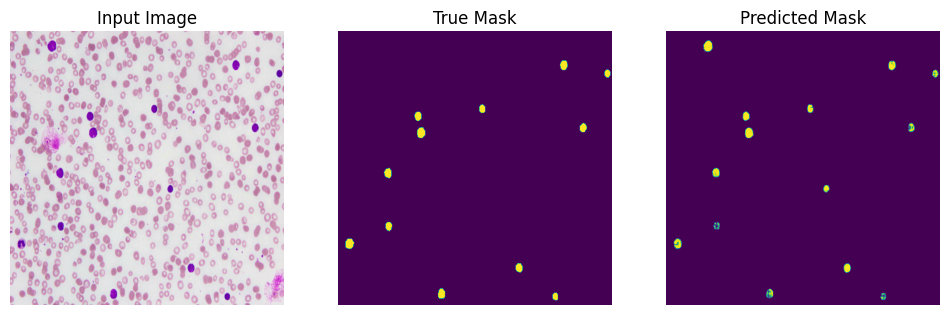

Epoch 27/30
11/11 [==============================] - 286s 26s/step - loss: 0.1391 - dice_coef: 0.8606 - binary_accuracy: 0.9991 - val_loss: 0.2703 - val_dice_coef: 0.7302 - val_binary_accuracy: 0.9986
Epoch 28/30
11/11 [==============================] - 316s 29s/step - loss: 0.1652 - dice_coef: 0.8348 - binary_accuracy: 0.9990 - val_loss: 0.2371 - val_dice_coef: 0.7632 - val_binary_accuracy: 0.9987
Epoch 29/30
1/1 [==============================] - 0s 494ms/step


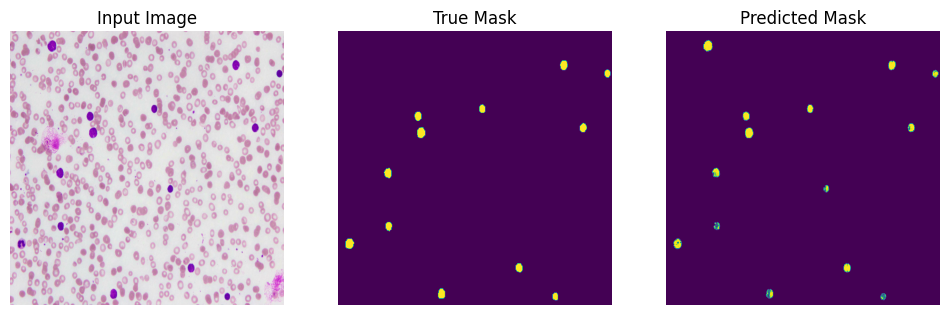

Epoch 30/30
11/11 [==============================] - 315s 29s/step - loss: 0.1322 - dice_coef: 0.8657 - binary_accuracy: 0.9992 - val_loss: 0.2513 - val_dice_coef: 0.7494 - val_binary_accuracy: 0.9987


In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 30
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

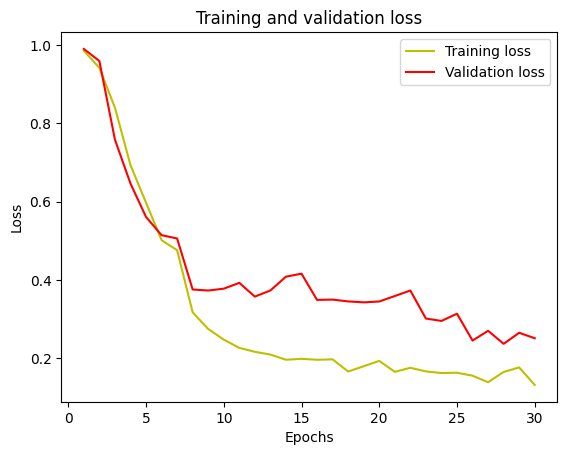

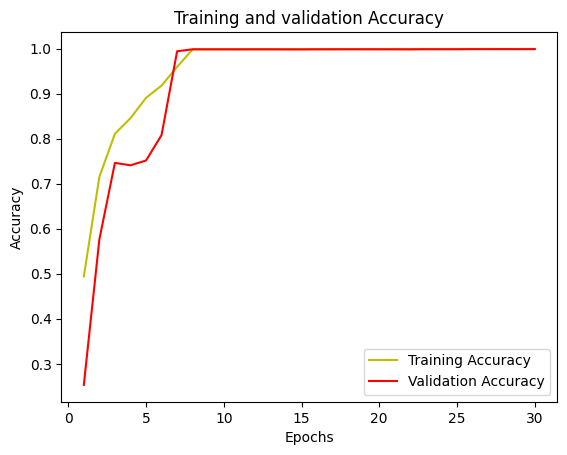

dict_keys(['loss', 'dice_coef', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_binary_accuracy'])


In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
history_dict = history.history
print(history_dict.keys())

In [ ]:
# Function to apply thresholding to predicted mask
def threshold_mask(pred_mask, threshold=0.5):
    pred_mask_binary = (pred_mask > threshold).astype(np.uint8) * 255
    return pred_mask_binary

def visualize(display_list):
    plt.figure(figsize=(12, 12))
    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Dilated Mask', 'Thresholded Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        if i != 4:
          plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        else:
          plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='binary')
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0], img_size[1], 1)
    pred_mask_thresholded = threshold_mask(pred_mask)  # Apply thresholding
    kernel = np.ones((5, 5), np.uint8)                    # Apply dilation
    img_dilation = cv2.dilate(pred_mask_thresholded, kernel, iterations=1)  # Apply dilation
    img_dilation = img_dilation.reshape(img_size[0], img_size[1], 1)
    visualize([sample_image, sample_mask, pred_mask,img_dilation, pred_mask_thresholded,])
    return sample_image, sample_mask, pred_mask, pred_mask_thresholded

Deleted file: /content/cropped_roi_4.jpg
Deleted file: /content/cropped_roi_1.jpg
Deleted file: /content/cropped_roi_0.jpg
Deleted file: /content/cropped_roi_3.jpg
Deleted file: /content/cropped_roi_2.jpg
1/1 [==============================] - 1s 506ms/step


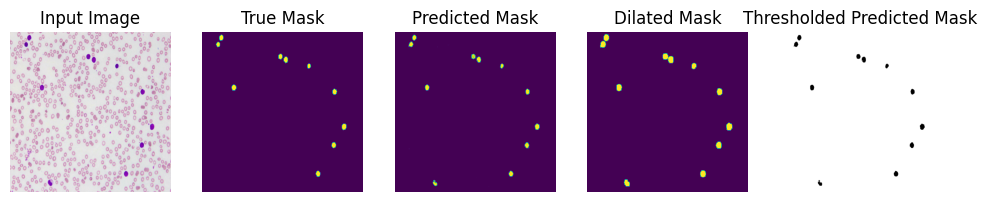

at bottom edge!
at top edge!
at top edge!
at top edge!
no contour detected
cellCount:  10


In [ ]:
counter = 0
countourCount = 0
deleteFiles()
kernel = np.ones((5, 5), np.uint8)
boxWidth = 64
boxHeight = 64
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        sample_image, sample_mask, pred_mask, pred_mask_thresholded = show_predictions(sample_image, sample_mask)
        img_dilation = cv2.dilate(pred_mask_thresholded, kernel, iterations=1)
        contours, _ = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # Initialize a counter for image filenames
        # Loop over the contours

        for contour in contours:
            countourCount+=1
            # Get bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)
            x-=10
            y-=10
            w = 64
            h = 64
            if int(x+74) >= img_dilation.shape[0]:
              print("at right edge!")
              x-=5
              if int(x+10) >= img_dilation.shape[0]:
                print("at right edge!")
                x-=20

            if int(x-15) <= 0:
              print("at left edge!")
              x+=5
              if int(x-5) <= 0:
                print("at left edge!")
                x+=5

            if int(y+54) >= img_dilation.shape[1]:
              print("at bottom edge!")
              y+=5
              if int(y+10) >= img_dilation.shape[1]:
                print("at bottom edge!")
                y+=5

            if int(y-54) <= 0:
              print("at top edge!")
              y-=5
              if int(y-10) <= 0:
                print("at top edge!")
                y-=20

            # Crop the ROI from the original image
            cropped_roi = (sample_image.numpy()[y:y+h, x:x+w])*255

            # Save the cropped ROI as a separate image
            try:
              cv2.imwrite(f'cropped_roi_{counter}.jpg', cropped_roi)
            except:

              print("no contour detected")

            # Increment the counter
            counter += 1
        print("cellCount: ", countourCount)
        countourCount = 0
        break


In [ ]:
#https://wandb.ai/ayush-thakur/dl-question-bank/reports/How-to-Handle-Images-of-Different-Sizes-in-a-Convolutional-Neural-Network--VmlldzoyMDk3NzQ

#affine